In [93]:
import numpy as np
from matplotlib import pyplot as plt
import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector

In [94]:
class quickReco:
    
    def __init__(self, name='', inputfile='', isTest=False):
        
        self.name = name
        self.delphesFile= uproot.open(inputfile)['Delphes']
        self.isTestRun = isTest
        
        # thresholds
        self.minLepPt  = 15
        self.maxLepEta = 2.5
        self.minJetPt  = 20
        self.maxJetEta = 2.5
    
        # variables unique for each event
        self.selectedMuons = []
        self.selectedElectrons = []
        self.selectedJets = []
        
        # variables to keep track
        self.nJets      = []
        self.nElectrons = []
        self.nMuons     = []
        self.HT         = []
        self.missingET  = []
        self.dileptonMass = []
        self.dileptonPT   = []
        self.dilepton_Jets = []
        self.jetCutflow = {'all':0, 'pt>{}'.format(self.minJetPt):0, '|eta|<{}'.format(self.maxJetEta):0}
        self.electronCutflow = {'all':0, 'pt>{}'.format(self.minLepPt):0, '|eta|<{}'.format(self.maxLepEta):0}
        self.muonCutflow = {'all':0, 'pt>{}'.format(self.minLepPt):0, '|eta|<{}'.format(self.maxLepEta):0}
        self.eventCutflow = {'all':0, 'El: >=2 lep':0, 'El: ==2 OS lep':0, 'El: Z window':0, 'Mu: >=2 lep':0, 'Mu: ==2 OS lep':0, 'Mu: Z window':0}
        
        # Branch Definitions
        self.l_jetPt     = []
        self.l_jetEta    = []
        self.l_jetPhi    = []
        self.l_jetMass   = []
        self.l_elPt      = []
        self.l_elEta     = []
        self.l_elPhi     = []
        self.l_elCharge  = []
        self.l_muPt      = []
        self.l_muEta     = []
        self.l_muPhi     = []
        self.l_muCharge  = []
        self.l_missingET_met  = []
        self.l_missingET_phi  = []
        self.l_scalarHT       = []
        
        
    def process(self):
        """main function for processing files"""
        
        # *** 0. Load Branches
        self.loadBranches()
        
        # *** 1. Loop over events
        for iEvent in range(0, len(self.delphesFile)):
           
            #keep track of events
            if iEvent%500 == 0:
                print("Processed {} events...".format(iEvent))
            
            #skip out if testRun
            if self.isTestRun and iEvent > 10:
                continue
            
            # ** A. Re-initialize collections
            self.selectedElectrons = []
            self.selectedMuons = []
            self.selectedJets = []
            
            # ** B. Object selection
            self.leptonSelection('Electron', iEvent)
            self.leptonSelection('Muon', iEvent)
            self.jetSelection(iEvent)

            # ** C. Event selection
            self.eventSelection(iEvent)
            

       # *** 2. Print some summaries
    
    
    def eventSelection(self, _iEvent):
        """function to select events"""
        
        #print("Evt: {}, N_electrons= {}, N_muons= {}".format(_iEvent, len(self.selectedElectrons), len(self.selectedMuons)))
        self.eventCutflow['all'] += 1
        
        if len(self.selectedElectrons) > 2 and len(self.selectedMuons)>2:
            print(">2 muons AND >2 electrons in Event {}. Ambiguous, so skipping...".format(_iEvent))
            return
        
        # ** 1. electron channel
        self.dileptonReco(self.selectedElectrons, 'electron', _iEvent)

        # ** 2. muon channel
        self.dileptonReco(self.selectedMuons, 'muon', _iEvent)

    def dileptonReco(self, _leptons, flavor, _iEvent):
        """helper function for dilepton reconstruction"""
        
        cutflowTag = 'El' if flavor=='electron' else 'Mu'
        
        if len( _leptons) >= 2:
            self.eventCutflow['{}: >=2 lep'.format(cutflowTag)] += 1
            
            if len(_leptons) == 2:
                lep0 = _leptons[0]
                lep1 = _leptons[1]
        
                if lep0[1]*lep1[1] == -1:
                    self.eventCutflow['{}: ==2 OS lep'.format(cutflowTag)] += 1
                    
                    m_ll = ( lep0[0] + lep1[0] ).mass
                    pt_ll = ( lep0[0] + lep1[0] ).pt
                    
                    self.dileptonMass.append( m_ll)
                    self.dileptonPT.append( pt_ll)
                    self.dilepton_Jets.append(self.nJets[_iEvent])
            
            elif len(_leptons) >2:
                print("Event {} has >2 {}. print (pT, charge)...".format(_iEvent, flavor))
                for lep in _leptons:
                    print("pt: {}, charge: {}".format(lep[0].pt, lep[1]))
                return
            
        else:
            return
            
    def leptonSelection(self, flavor, _iEvent):
        """function for performing lepton selection"""
        
        _selectedLeptons = []
        
        _pt     = self.l_elPt if flavor=='Electron' else self.l_muPt 
        _eta    = self.l_elEta if flavor=='Electron' else self.l_muEta 
        _phi    = self.l_elPhi if flavor=='Electron' else self.l_muPhi
        _charge = self.l_elCharge if flavor=='Electron' else self.l_muCharge 
        _mass   = 0.511 * 1e-3 if flavor == 'Electron' else 105.6*1e-3 # need conversion 1e-3 for MeV to GeV
        
        for iLep in range(0, len(_pt[_iEvent])): 
            if flavor=='Electron':
                self.electronCutflow['all'] += 1
            elif flavor=='Muon':
                self.muonCutflow['all'] += 1
             
            # ** A. Check pt above min threshold
            if _pt[_iEvent][iLep] < self.minLepPt:
                continue
                
            if flavor=='Electron':
                self.electronCutflow['pt>{}'.format(self.minLepPt)] += 1
            elif flavor=='Muon':
                self.muonCutflow['pt>{}'.format(self.minLepPt)] += 1
                
            # ** B. Check eta inside max abs eta range
            if np.abs(_eta[_iEvent][iLep]) > self.maxLepEta:
                continue

            if flavor=='Electron':
                self.electronCutflow['|eta|<{}'.format(self.maxLepEta)] += 1
            elif flavor=='Muon':
                self.muonCutflow['|eta|<{}'.format(self.maxLepEta)] += 1
            
            # ** C. Make LorentzVector and store
            _tlv = TLorentzVector.PtEtaPhiMassLorentzVector( _pt[_iEvent][iLep], _eta[_iEvent][iLep], _phi[_iEvent][iLep], _mass)
            _selectedLeptons.append( (_tlv, _charge[_iEvent][iLep]) )
            
            
        # some global stuff after selection        
        if flavor=='Electron':
            self.selectedElectrons = _selectedLeptons
            self.nElectrons.append( len(_selectedLeptons))
        elif flavor=='Muon':
            self.selectedMuons = _selectedLeptons
            self.nMuons.append( len(_selectedLeptons))
                
                
    def jetSelection(self, _iEvent):
        """function for performing jet selection"""
        
        _selectedJets = []
        
        _pt     = self.l_jetPt  
        _eta    = self.l_jetEta 
        _phi    = self.l_jetPhi
        _mass   = self.l_jetMass

        for iJet in range(0, len(_pt[_iEvent])): 
            self.jetCutflow['all'] += 1
             
            # ** A. Check pt above min threshold
            if _pt[_iEvent][iJet] < self.minJetPt:
                continue
                
            self.jetCutflow['pt>{}'.format(self.minJetPt)] += 1
                
            # ** B. Check eta inside max abs eta range
            if np.abs(_eta[_iEvent][iJet]) > self.maxJetEta:
                continue

            self.jetCutflow['|eta|<{}'.format(self.maxJetEta)] += 1
            
            # ** C. Make LorentzVector and store
            _tlv = TLorentzVector.PtEtaPhiMassLorentzVector( _pt[_iEvent][iJet], _eta[_iEvent][iJet], _phi[_iEvent][iJet], _mass[_iEvent][iJet])
            _selectedJets.append( _tlv )
            
        # some global stuff after selection        
        self.selectedJets = _selectedJets
        self.nJets.append( len(_selectedJets))
       

        
    def loadBranches(self):
        """function for loading branches from delphes file"""
            
        # branches
        self.l_jetPt   = uproot.tree.TBranchMethods.array(self.delphesFile['Jet']['Jet.PT']).tolist()
        self.l_jetEta  = uproot.tree.TBranchMethods.array(self.delphesFile['Jet']['Jet.Eta']).tolist()
        self.l_jetPhi  = uproot.tree.TBranchMethods.array(self.delphesFile['Jet']['Jet.Phi']).tolist()
        self.l_jetMass = uproot.tree.TBranchMethods.array(self.delphesFile['Jet']['Jet.Mass']).tolist()
        
        self.l_elPt     = uproot.tree.TBranchMethods.array(self.delphesFile['Electron']['Electron.PT']).tolist()
        self.l_elEta    = uproot.tree.TBranchMethods.array(self.delphesFile['Electron']['Electron.Eta']).tolist()
        self.l_elPhi    = uproot.tree.TBranchMethods.array(self.delphesFile['Electron']['Electron.Phi']).tolist()
        self.l_elCharge = uproot.tree.TBranchMethods.array(self.delphesFile['Electron']['Electron.Charge']).tolist()
       
        self.l_muPt     = uproot.tree.TBranchMethods.array(self.delphesFile['Muon']['Muon.PT']).tolist()
        self.l_muEta    = uproot.tree.TBranchMethods.array(self.delphesFile['Muon']['Muon.Eta']).tolist()
        self.l_muPhi    = uproot.tree.TBranchMethods.array(self.delphesFile['Muon']['Muon.Phi']).tolist()
        self.l_muCharge = uproot.tree.TBranchMethods.array(self.delphesFile['Muon']['Muon.Charge']).tolist()
        
        self.l_missingET_met  = uproot.tree.TBranchMethods.array(self.delphesFile['MissingET']['MissingET.MET']).tolist()
        self.l_missingET_phi  = uproot.tree.TBranchMethods.array(self.delphesFile['MissingET']['MissingET.Phi']).tolist()
        self.l_scalarHT       = uproot.tree.TBranchMethods.array(self.delphesFile['ScalarHT']['ScalarHT.HT']).tolist()
        
        print("Finished loading branches...")

In [95]:
pp2ll_1_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_1_ll_delphes_events.root')
pp2ll_2_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_2_ll_delphes_events.root')
pp2ll_3_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_3_ll_delphes_events.root')
pp2ll_4_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_4_ll_delphes_events.root')
pp2ll_5_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_5_ll_delphes_events.root')
pp2ll_6_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_6_ll_delphes_events.root')
pp2ll_7_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_7_ll_delphes_events.root')
pp2ll_8_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_8_ll_delphes_events.root')
pp2ll_9_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_9_ll_delphes_events.root')
pp2ll_10_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_10_ll_delphes_events.root')
pp2ll_11_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_11_ll_delphes_events.root')
pp2ll_12_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_12_ll_delphes_events.root')
pp2ll_13_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_13_ll_delphes_events.root')
pp2ll_14_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_14_ll_delphes_events.root')
pp2ll_15_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_15_ll_delphes_events.root')
pp2ll_16_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_16_ll_delphes_events.root')
pp2ll_17_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_17_ll_delphes_events.root')
pp2ll_18_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_18_ll_delphes_events.root')
pp2ll_19_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_19_ll_delphes_events.root')
pp2ll_20_reco = quickReco('pp2ll_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOll_background\\seed_20_ll_delphes_events.root')

pp2ll_1_reco.process()
pp2ll_2_reco.process()
pp2ll_3_reco.process()
pp2ll_4_reco.process()
pp2ll_5_reco.process()
pp2ll_6_reco.process()
pp2ll_7_reco.process()
pp2ll_8_reco.process()
pp2ll_9_reco.process()
pp2ll_10_reco.process()
pp2ll_11_reco.process()
pp2ll_12_reco.process()
pp2ll_13_reco.process()
pp2ll_14_reco.process()
pp2ll_15_reco.process()
pp2ll_16_reco.process()
pp2ll_17_reco.process()
pp2ll_18_reco.process()
pp2ll_19_reco.process()
pp2ll_20_reco.process()

Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Event 2219 has >2 electron. print (pT, charge)...
pt: 32.233238220214844, charge: -1
pt: 16.43926239013672, charge: 1
pt: 15.273909568786621, charge: -1
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branc

In [96]:
pp2ll_dilepton_mass = []
pp2ll_dilepton_PT = []
pp2ll_dilepton_Jets = []
pp2ll_nJets = []
pp2ll_met_array = []
pp2ll_sht_array = []

for i,arr in enumerate (pp2ll_1_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)    
for i,arr in enumerate (pp2ll_2_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)   
for i,arr in enumerate (pp2ll_3_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)     
for i,arr in enumerate (pp2ll_4_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
for i,arr in enumerate (pp2ll_5_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
for i,arr in enumerate (pp2ll_6_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)    
for i,arr in enumerate (pp2ll_7_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)   
for i,arr in enumerate (pp2ll_8_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)     
for i,arr in enumerate (pp2ll_9_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
for i,arr in enumerate (pp2ll_10_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
for i,arr in enumerate (pp2ll_11_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)    
for i,arr in enumerate (pp2ll_12_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)   
for i,arr in enumerate (pp2ll_13_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)     
for i,arr in enumerate (pp2ll_14_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
for i,arr in enumerate (pp2ll_15_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
for i,arr in enumerate (pp2ll_16_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)    
for i,arr in enumerate (pp2ll_17_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)   
for i,arr in enumerate (pp2ll_18_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)     
for i,arr in enumerate (pp2ll_19_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
for i,arr in enumerate (pp2ll_20_reco.dileptonMass):pp2ll_dilepton_mass.append(arr)
        
for i,arr in enumerate (pp2ll_1_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2ll_2_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2ll_3_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2ll_4_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
for i,arr in enumerate (pp2ll_5_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
for i,arr in enumerate (pp2ll_6_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2ll_7_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2ll_8_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2ll_9_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
for i,arr in enumerate (pp2ll_10_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
for i,arr in enumerate (pp2ll_11_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2ll_12_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2ll_13_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2ll_14_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
for i,arr in enumerate (pp2ll_15_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
for i,arr in enumerate (pp2ll_16_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2ll_17_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2ll_18_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2ll_19_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
for i,arr in enumerate (pp2ll_20_reco.dileptonPT):pp2ll_dilepton_PT.append(arr)
    
for i,arr in enumerate (pp2ll_1_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2ll_2_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2ll_3_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2ll_4_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2ll_5_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2ll_6_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2ll_7_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2ll_8_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2ll_9_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2ll_10_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2ll_11_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2ll_12_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2ll_13_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2ll_14_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2ll_15_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2ll_16_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2ll_17_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2ll_18_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2ll_19_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2ll_20_reco.dilepton_Jets):pp2ll_dilepton_Jets.append(arr)
    
for i,arr in enumerate (pp2ll_1_reco.nJets):pp2ll_nJets.append(arr)    
for i,arr in enumerate (pp2ll_2_reco.nJets):pp2ll_nJets.append(arr)   
for i,arr in enumerate (pp2ll_3_reco.nJets):pp2ll_nJets.append(arr)     
for i,arr in enumerate (pp2ll_4_reco.nJets):pp2ll_nJets.append(arr)
for i,arr in enumerate (pp2ll_5_reco.nJets):pp2ll_nJets.append(arr)
for i,arr in enumerate (pp2ll_6_reco.nJets):pp2ll_nJets.append(arr)    
for i,arr in enumerate (pp2ll_7_reco.nJets):pp2ll_nJets.append(arr)   
for i,arr in enumerate (pp2ll_8_reco.nJets):pp2ll_nJets.append(arr)     
for i,arr in enumerate (pp2ll_9_reco.nJets):pp2ll_nJets.append(arr)
for i,arr in enumerate (pp2ll_10_reco.nJets):pp2ll_nJets.append(arr)
for i,arr in enumerate (pp2ll_11_reco.nJets):pp2ll_nJets.append(arr)    
for i,arr in enumerate (pp2ll_12_reco.nJets):pp2ll_nJets.append(arr)   
for i,arr in enumerate (pp2ll_13_reco.nJets):pp2ll_nJets.append(arr)     
for i,arr in enumerate (pp2ll_14_reco.nJets):pp2ll_nJets.append(arr)
for i,arr in enumerate (pp2ll_15_reco.nJets):pp2ll_nJets.append(arr)
for i,arr in enumerate (pp2ll_16_reco.nJets):pp2ll_nJets.append(arr)    
for i,arr in enumerate (pp2ll_17_reco.nJets):pp2ll_nJets.append(arr)   
for i,arr in enumerate (pp2ll_18_reco.nJets):pp2ll_nJets.append(arr)     
for i,arr in enumerate (pp2ll_19_reco.nJets):pp2ll_nJets.append(arr)
for i,arr in enumerate (pp2ll_20_reco.nJets):pp2ll_nJets.append(arr)

In [97]:
pp2lljj_1_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_1_lljj_delphes_events.root')
pp2lljj_2_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_2_lljj_delphes_events.root')
pp2lljj_3_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_3_lljj_delphes_events.root')
pp2lljj_4_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_4_lljj_delphes_events.root')
pp2lljj_5_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_5_lljj_delphes_events.root')
pp2lljj_6_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_6_lljj_delphes_events.root')
pp2lljj_7_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_7_lljj_delphes_events.root')
pp2lljj_8_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_8_lljj_delphes_events.root')
pp2lljj_9_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_9_lljj_delphes_events.root')
pp2lljj_10_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_10_lljj_delphes_events.root')
pp2lljj_11_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_11_lljj_delphes_events.root')
pp2lljj_12_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_12_lljj_delphes_events.root')
pp2lljj_13_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_13_lljj_delphes_events.root')
pp2lljj_14_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_14_lljj_delphes_events.root')
pp2lljj_15_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_15_lljj_delphes_events.root')
pp2lljj_16_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_16_lljj_delphes_events.root')
pp2lljj_17_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_17_lljj_delphes_events.root')
pp2lljj_18_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_18_lljj_delphes_events.root')
pp2lljj_19_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_19_lljj_delphes_events.root')
pp2lljj_20_reco = quickReco('pp2lljj_SM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOlljj_background\\seed_20_lljj_delphes_events.root')

pp2lljj_1_reco.process()
pp2lljj_2_reco.process()
pp2lljj_3_reco.process()
pp2lljj_4_reco.process()
pp2lljj_5_reco.process()
pp2lljj_6_reco.process()
pp2lljj_7_reco.process()
pp2lljj_8_reco.process()
pp2lljj_9_reco.process()
pp2lljj_10_reco.process()
pp2lljj_11_reco.process()
pp2lljj_12_reco.process()
pp2lljj_13_reco.process()
pp2lljj_14_reco.process()
pp2lljj_15_reco.process()
pp2lljj_16_reco.process()
pp2lljj_17_reco.process()
pp2lljj_18_reco.process()
pp2lljj_19_reco.process()
pp2lljj_20_reco.process()

Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...


In [98]:
pp2lljj_dilepton_mass = []
pp2lljj_dilepton_PT = []
pp2lljj_dilepton_Jets = []
pp2lljj_nJets = []
pp2lljj_met_array = []
pp2lljj_sht_array = []

for i,arr in enumerate (pp2lljj_1_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2lljj_2_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_3_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_4_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_5_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_6_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2lljj_7_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_8_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_9_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_10_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_11_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2lljj_12_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_13_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_14_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_15_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_16_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2lljj_17_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_18_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_19_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)
for i,arr in enumerate (pp2lljj_20_reco.dileptonMass):pp2lljj_dilepton_mass.append(arr)

for i,arr in enumerate (pp2lljj_1_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2lljj_2_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2lljj_3_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2lljj_4_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)
for i,arr in enumerate (pp2lljj_5_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)
for i,arr in enumerate (pp2lljj_6_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2lljj_7_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2lljj_8_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2lljj_9_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)
for i,arr in enumerate (pp2lljj_10_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)
for i,arr in enumerate (pp2lljj_11_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2lljj_12_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2lljj_13_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2lljj_14_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)
for i,arr in enumerate (pp2lljj_15_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)
for i,arr in enumerate (pp2lljj_16_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2lljj_17_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2lljj_18_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2lljj_19_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)
for i,arr in enumerate (pp2lljj_20_reco.dileptonPT):pp2lljj_dilepton_PT.append(arr)

for i,arr in enumerate (pp2lljj_1_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2lljj_2_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2lljj_3_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2lljj_4_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2lljj_5_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2lljj_6_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2lljj_7_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2lljj_8_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2lljj_9_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2lljj_10_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2lljj_11_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2lljj_12_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2lljj_13_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2lljj_14_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2lljj_15_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2lljj_16_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2lljj_17_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2lljj_18_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2lljj_19_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2lljj_20_reco.dilepton_Jets):pp2lljj_dilepton_Jets.append(arr)
    
for i,arr in enumerate (pp2lljj_1_reco.nJets):pp2lljj_nJets.append(arr)    
for i,arr in enumerate (pp2lljj_2_reco.nJets):pp2lljj_nJets.append(arr)   
for i,arr in enumerate (pp2lljj_3_reco.nJets):pp2lljj_nJets.append(arr)     
for i,arr in enumerate (pp2lljj_4_reco.nJets):pp2lljj_nJets.append(arr)
for i,arr in enumerate (pp2lljj_5_reco.nJets):pp2lljj_nJets.append(arr)
for i,arr in enumerate (pp2lljj_6_reco.nJets):pp2lljj_nJets.append(arr)    
for i,arr in enumerate (pp2lljj_7_reco.nJets):pp2lljj_nJets.append(arr)   
for i,arr in enumerate (pp2lljj_8_reco.nJets):pp2lljj_nJets.append(arr)     
for i,arr in enumerate (pp2lljj_9_reco.nJets):pp2lljj_nJets.append(arr)
for i,arr in enumerate (pp2lljj_10_reco.nJets):pp2lljj_nJets.append(arr)
for i,arr in enumerate (pp2lljj_11_reco.nJets):pp2lljj_nJets.append(arr)    
for i,arr in enumerate (pp2lljj_12_reco.nJets):pp2lljj_nJets.append(arr)   
for i,arr in enumerate (pp2lljj_13_reco.nJets):pp2lljj_nJets.append(arr)     
for i,arr in enumerate (pp2lljj_14_reco.nJets):pp2lljj_nJets.append(arr)
for i,arr in enumerate (pp2lljj_15_reco.nJets):pp2lljj_nJets.append(arr)
for i,arr in enumerate (pp2lljj_16_reco.nJets):pp2lljj_nJets.append(arr)    
for i,arr in enumerate (pp2lljj_17_reco.nJets):pp2lljj_nJets.append(arr)   
for i,arr in enumerate (pp2lljj_18_reco.nJets):pp2lljj_nJets.append(arr)     
for i,arr in enumerate (pp2lljj_19_reco.nJets):pp2lljj_nJets.append(arr)
for i,arr in enumerate (pp2lljj_20_reco.nJets):pp2lljj_nJets.append(arr)

In [99]:
pp2llxdxd_1_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_1_xdxd_delphes_events.root')
pp2llxdxd_2_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_2_xdxd_delphes_events.root')
pp2llxdxd_3_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_3_xdxd_delphes_events.root')
pp2llxdxd_4_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_4_xdxd_delphes_events.root')
pp2llxdxd_5_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_5_xdxd_delphes_events.root')
pp2llxdxd_6_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_6_xdxd_delphes_events.root')
pp2llxdxd_7_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_7_xdxd_delphes_events.root')
pp2llxdxd_8_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_8_xdxd_delphes_events.root')
pp2llxdxd_9_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_9_xdxd_delphes_events.root')
pp2llxdxd_10_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_10_xdxd_delphes_events.root')
pp2llxdxd_11_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_11_xdxd_delphes_events.root')
pp2llxdxd_12_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_12_xdxd_delphes_events.root')
pp2llxdxd_13_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_13_xdxd_delphes_events.root')
pp2llxdxd_14_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_14_xdxd_delphes_events.root')
pp2llxdxd_15_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_15_xdxd_delphes_events.root')
pp2llxdxd_16_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_16_xdxd_delphes_events.root')
pp2llxdxd_17_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_17_xdxd_delphes_events.root')
pp2llxdxd_18_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_18_xdxd_delphes_events.root')
pp2llxdxd_19_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_19_xdxd_delphes_events.root')
pp2llxdxd_20_reco   = quickReco('pp2ll_DM', 'C:\\Users\\student\\Desktop\\College\\Summer_2020\\Research\\ppTOllxdxd_signal\\seed_20_xdxd_delphes_events.root')

pp2llxdxd_1_reco.process()
pp2llxdxd_2_reco.process()
pp2llxdxd_3_reco.process()
pp2llxdxd_4_reco.process()
pp2llxdxd_5_reco.process()
pp2llxdxd_6_reco.process()
pp2llxdxd_7_reco.process()
pp2llxdxd_8_reco.process()
pp2llxdxd_9_reco.process()
pp2llxdxd_10_reco.process()
pp2llxdxd_11_reco.process()
pp2llxdxd_12_reco.process()
pp2llxdxd_13_reco.process()
pp2llxdxd_14_reco.process()
pp2llxdxd_15_reco.process()
pp2llxdxd_16_reco.process()
pp2llxdxd_17_reco.process()
pp2llxdxd_18_reco.process()
pp2llxdxd_19_reco.process()
pp2llxdxd_20_reco.process()

Finished loading branches...
Processed 0 events...
Event 435 has >2 electron. print (pT, charge)...
pt: 110.30042266845703, charge: 1
pt: 40.64705276489258, charge: -1
pt: 23.151653289794922, charge: 1
Processed 500 events...
Processed 1000 events...
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Event 1001 has >2 muon. print (pT, charge)...
pt: 91.60366821289062, charge: -1
pt: 40.6368293762207, charge: 1
pt: 29.955123901367188, charge: 1
pt: 23.294166564941406, charge: -1
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...
Processed 1500 eve

Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Event 637 has >2 muon. print (pT, charge)...
pt: 102.18091583251953, charge: -1
pt: 82.58184051513672, charge: 1
pt: 16.686840057373047, charge: 1
Processed 1000 events...
Event 1186 has >2 electron. print (pT, charge)...
pt: 78.4280776977539, charge: 1
pt: 33.43732833862305, charge: 1
pt: 23.602909088134766, charge: -1
Processed 1500 events...
Processed 2000 events...
Processed 2500 events...
Event 2555 has >2 electron. print (pT, charge)...
pt: 102.33537292480469, charge: 1
pt: 69.66944122314453, charge: -1
pt: 19.307601928710938, charge: -1
Processed 3000 events...
Processed 3500 events...
Processed 4000 events...
Processed 4500 events...
Finished loading branches...
Processed 0 events...
Processed 500 events...
Processed 1000 events...


In [100]:
pp2llxdxd_dilepton_mass = []
pp2llxdxd_dilepton_PT = []
pp2llxdxd_dilepton_Jets = []
pp2llxdxd_nJets = []
pp2llxdxd_met_array = []
pp2llxdxd_sht_array = []

for i,arr in enumerate (pp2llxdxd_1_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2llxdxd_2_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_3_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_4_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_5_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_6_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2llxdxd_7_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_8_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_9_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_10_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_11_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2llxdxd_12_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_13_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_14_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_15_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_16_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr) 
for i,arr in enumerate (pp2llxdxd_17_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_18_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_19_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
for i,arr in enumerate (pp2llxdxd_20_reco.dileptonMass):pp2llxdxd_dilepton_mass.append(arr)
    
for i,arr in enumerate (pp2llxdxd_1_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2llxdxd_2_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2llxdxd_3_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2llxdxd_4_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
for i,arr in enumerate (pp2llxdxd_5_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
for i,arr in enumerate (pp2llxdxd_6_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2llxdxd_7_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2llxdxd_8_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2llxdxd_9_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
for i,arr in enumerate (pp2llxdxd_10_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
for i,arr in enumerate (pp2llxdxd_11_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2llxdxd_12_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2llxdxd_13_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2llxdxd_14_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
for i,arr in enumerate (pp2llxdxd_15_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
for i,arr in enumerate (pp2llxdxd_16_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)    
for i,arr in enumerate (pp2llxdxd_17_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)   
for i,arr in enumerate (pp2llxdxd_18_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)     
for i,arr in enumerate (pp2llxdxd_19_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
for i,arr in enumerate (pp2llxdxd_20_reco.dileptonPT):pp2llxdxd_dilepton_PT.append(arr)
    
for i,arr in enumerate (pp2llxdxd_1_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2llxdxd_2_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2llxdxd_3_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2llxdxd_4_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2llxdxd_5_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2llxdxd_6_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2llxdxd_7_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2llxdxd_8_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2llxdxd_9_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2llxdxd_10_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2llxdxd_11_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2llxdxd_12_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2llxdxd_13_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2llxdxd_14_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2llxdxd_15_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2llxdxd_16_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)    
for i,arr in enumerate (pp2llxdxd_17_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)   
for i,arr in enumerate (pp2llxdxd_18_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)     
for i,arr in enumerate (pp2llxdxd_19_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
for i,arr in enumerate (pp2llxdxd_20_reco.dilepton_Jets):pp2llxdxd_dilepton_Jets.append(arr)
    
for i,arr in enumerate (pp2llxdxd_1_reco.nJets):pp2llxdxd_nJets.append(arr)    
for i,arr in enumerate (pp2llxdxd_2_reco.nJets):pp2llxdxd_nJets.append(arr)   
for i,arr in enumerate (pp2llxdxd_3_reco.nJets):pp2llxdxd_nJets.append(arr)     
for i,arr in enumerate (pp2llxdxd_4_reco.nJets):pp2llxdxd_nJets.append(arr)
for i,arr in enumerate (pp2llxdxd_5_reco.nJets):pp2llxdxd_nJets.append(arr)
for i,arr in enumerate (pp2llxdxd_6_reco.nJets):pp2llxdxd_nJets.append(arr)    
for i,arr in enumerate (pp2llxdxd_7_reco.nJets):pp2llxdxd_nJets.append(arr)   
for i,arr in enumerate (pp2llxdxd_8_reco.nJets):pp2llxdxd_nJets.append(arr)     
for i,arr in enumerate (pp2llxdxd_9_reco.nJets):pp2llxdxd_nJets.append(arr)
for i,arr in enumerate (pp2llxdxd_10_reco.nJets):pp2llxdxd_nJets.append(arr)
for i,arr in enumerate (pp2llxdxd_11_reco.nJets):pp2llxdxd_nJets.append(arr)    
for i,arr in enumerate (pp2llxdxd_12_reco.nJets):pp2llxdxd_nJets.append(arr)   
for i,arr in enumerate (pp2llxdxd_13_reco.nJets):pp2llxdxd_nJets.append(arr)     
for i,arr in enumerate (pp2llxdxd_14_reco.nJets):pp2llxdxd_nJets.append(arr)
for i,arr in enumerate (pp2llxdxd_15_reco.nJets):pp2llxdxd_nJets.append(arr)
for i,arr in enumerate (pp2llxdxd_16_reco.nJets):pp2llxdxd_nJets.append(arr)    
for i,arr in enumerate (pp2llxdxd_17_reco.nJets):pp2llxdxd_nJets.append(arr)   
for i,arr in enumerate (pp2llxdxd_18_reco.nJets):pp2llxdxd_nJets.append(arr)     
for i,arr in enumerate (pp2llxdxd_19_reco.nJets):pp2llxdxd_nJets.append(arr)
for i,arr in enumerate (pp2llxdxd_20_reco.nJets):pp2llxdxd_nJets.append(arr)

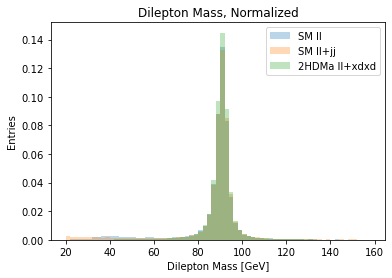

In [116]:
plt.hist(pp2ll_dilepton_mass, bins=np.arange(20,160,2), alpha=0.3, label='SM ll', density = True)
plt.hist(pp2lljj_dilepton_mass, bins=np.arange(20,160,2), alpha=0.3, label='SM ll+jj', density = True)
plt.hist(pp2llxdxd_dilepton_mass, bins=np.arange(20,160,2), alpha=0.3, label='2HDMa ll+xdxd', density = True)
plt.title('Dilepton Mass, Normalized')
plt.xlabel('Dilepton Mass [GeV]')
plt.ylabel('Entries')
plt.legend()
plt.show()

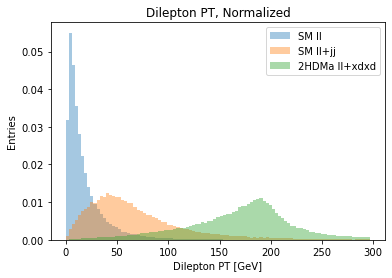

In [115]:
plt.hist(pp2ll_dilepton_PT, bins=np.arange(0,300,3), alpha=0.4, label='SM ll', density = True)
plt.hist(pp2lljj_dilepton_PT, bins=np.arange(0,300,3), alpha=0.4, label='SM ll+jj', density = True)
plt.hist(pp2llxdxd_dilepton_PT, bins=np.arange(0,300,3), alpha=0.4, label='2HDMa ll+xdxd', density = True)
plt.title('Dilepton PT, Normalized')
plt.xlabel('Dilepton PT [GeV]')
plt.ylabel('Entries')
plt.legend()
plt.show()


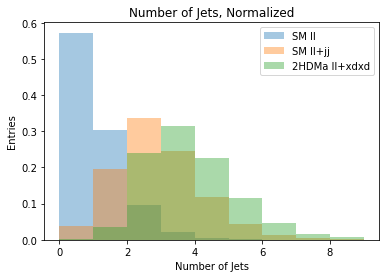

In [103]:
plt.hist(pp2ll_nJets, bins=np.arange(0,10), alpha=0.4, label='SM ll', density = True)
plt.hist(pp2lljj_nJets, bins=np.arange(0,10), alpha=0.4, label='SM ll+jj', density = True)
plt.hist(pp2llxdxd_nJets, bins=np.arange(0,10), alpha=0.4, label='2HDMa ll+xdxd', density = True)
plt.title('Number of Jets, Normalized')
plt.xlabel('Number of Jets')
plt.ylabel('Entries')
plt.legend()
plt.show()


In [104]:
for i,arr in enumerate (pp2ll_1_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
                
for i,arr in enumerate (pp2ll_2_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_3_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_4_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_5_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_6_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
                
for i,arr in enumerate (pp2ll_7_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_8_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_9_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_10_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)

for i,arr in enumerate (pp2ll_11_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
                
for i,arr in enumerate (pp2ll_12_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_13_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_14_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_15_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_16_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
                
for i,arr in enumerate (pp2ll_17_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_18_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_19_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)
        
for i,arr in enumerate (pp2ll_20_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2ll_met_array.append(value)

In [105]:
for i,arr in enumerate (pp2lljj_1_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_2_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)

for i,arr in enumerate (pp2lljj_3_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_4_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_5_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_6_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_7_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)

for i,arr in enumerate (pp2lljj_8_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_9_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_10_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_11_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_12_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)

for i,arr in enumerate (pp2lljj_13_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_14_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_15_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_16_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_17_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)

for i,arr in enumerate (pp2lljj_18_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_19_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)
        
for i,arr in enumerate (pp2lljj_20_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2lljj_met_array.append(value)

In [106]:
for i,arr in enumerate (pp2llxdxd_1_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_2_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_3_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_4_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_5_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_6_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_7_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_8_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_9_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_10_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_11_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_12_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_13_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_14_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_15_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_16_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_17_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

for i,arr in enumerate (pp2llxdxd_18_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_19_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_20_reco.l_missingET_met):
    for j,value in enumerate(arr):pp2llxdxd_met_array.append(value)

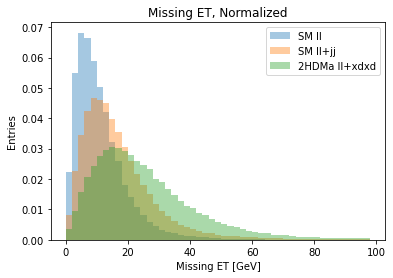

In [107]:
plt.hist(pp2ll_met_array, bins=np.arange(0,100,2), alpha=0.4, label='SM ll', density = True)
plt.hist(pp2lljj_met_array, bins=np.arange(0,100,2), alpha=0.4, label='SM ll+jj', density = True)
plt.hist(pp2llxdxd_met_array, bins=np.arange(0,100,2), alpha=0.4, label='2HDMa ll+xdxd', density = True)
plt.title('Missing ET, Normalized')
plt.xlabel('Missing ET [GeV]')
plt.ylabel('Entries')
plt.legend()
plt.show()

In [108]:
for i,arr in enumerate (pp2ll_1_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)

for i,arr in enumerate (pp2ll_2_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_3_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_4_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_5_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_6_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)

for i,arr in enumerate (pp2ll_7_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_8_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_9_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_10_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_11_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)

for i,arr in enumerate (pp2ll_12_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_13_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_14_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_15_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_16_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)

for i,arr in enumerate (pp2ll_17_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_18_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_19_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)
        
for i,arr in enumerate (pp2ll_20_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2ll_sht_array.append(value)

In [109]:
for i,arr in enumerate (pp2lljj_1_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_2_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_3_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_4_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_5_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_6_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_7_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_8_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_9_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_10_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_11_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_12_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_13_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_14_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_15_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_16_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_17_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_18_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_19_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)
        
for i,arr in enumerate (pp2lljj_20_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2lljj_sht_array.append(value)

In [110]:
for i,arr in enumerate (pp2llxdxd_1_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_2_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_3_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_4_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_5_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_6_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_7_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_8_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_9_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_10_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_11_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_12_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_13_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_14_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_15_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_16_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_17_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_18_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_19_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)
        
for i,arr in enumerate (pp2llxdxd_20_reco.l_scalarHT):
    for j,value in enumerate(arr):pp2llxdxd_sht_array.append(value)

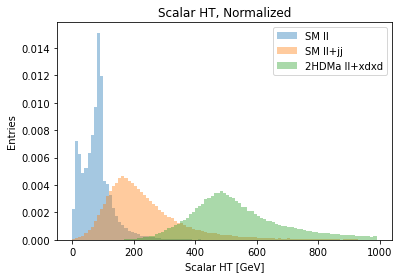

In [111]:
plt.hist(pp2ll_sht_array, bins=np.arange(0,1000,10), alpha=0.4, label='SM ll', density = True)
plt.hist(pp2lljj_sht_array, bins=np.arange(0,1000,10), alpha=0.4, label='SM ll+jj', density = True)
plt.hist(pp2llxdxd_sht_array, bins=np.arange(0,1000,10), alpha=0.4, label='2HDMa ll+xdxd' , density = True)
plt.title('Scalar HT, Normalized')
plt.xlabel('Scalar HT [GeV]')
plt.ylabel('Entries')
plt.legend()
plt.show()

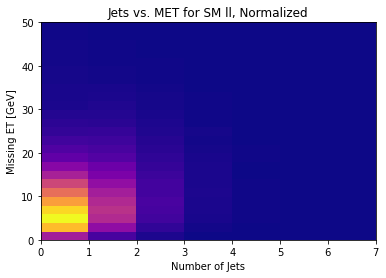

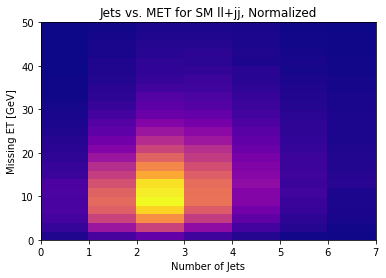

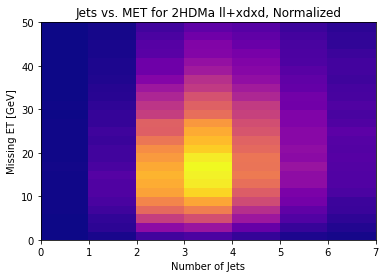

In [112]:
plt.hist2d(pp2ll_nJets,pp2ll_met_array , bins = [7,25], density=True, cmap='plasma', range=((0,7),(0,50)))
plt.title("Jets vs. MET for SM ll, Normalized")
plt.xlabel("Number of Jets")
plt.ylabel("Missing ET [GeV]")
plt.show()

plt.hist2d(pp2lljj_nJets, pp2lljj_met_array, bins=[7,25], density=True, cmap='plasma', range=((0,7),(0,50)))
plt.title("Jets vs. MET for SM ll+jj, Normalized")
plt.xlabel("Number of Jets")
plt.ylabel("Missing ET [GeV]")
plt.show()

plt.hist2d(pp2llxdxd_nJets, pp2llxdxd_met_array, bins = [7,25], density=True, cmap='plasma', range=((0,7),(0,50)))
plt.title("Jets vs. MET for 2HDMa ll+xdxd, Normalized")
plt.xlabel("Number of Jets")
plt.ylabel("Missing ET [GeV]")
plt.show()

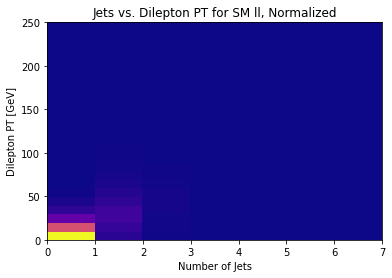

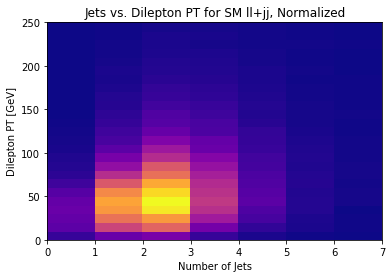

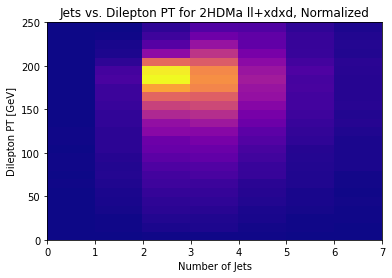

In [113]:
plt.hist2d(pp2ll_dilepton_Jets ,pp2ll_dilepton_PT , bins = [7,25], density= True, cmap='plasma',range=((0,7),(0,250)))
plt.title("Jets vs. Dilepton PT for SM ll, Normalized")
plt.xlabel("Number of Jets")
plt.ylabel("Dilepton PT [GeV]")
plt.show()

plt.hist2d(pp2lljj_dilepton_Jets ,pp2lljj_dilepton_PT , bins = [7,25], density= True, cmap='plasma',range=((0,7),(0,250)))
plt.title("Jets vs. Dilepton PT for SM ll+jj, Normalized")
plt.xlabel("Number of Jets")
plt.ylabel("Dilepton PT [GeV]")
plt.show()

plt.hist2d(pp2llxdxd_dilepton_Jets ,pp2llxdxd_dilepton_PT , bins = [7,25], density= True, cmap='plasma',range=((0,7),(0,250)))
plt.title("Jets vs. Dilepton PT for 2HDMa ll+xdxd, Normalized")
plt.xlabel("Number of Jets")
plt.ylabel("Dilepton PT [GeV]")
plt.show()